In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [2]:
actors_df = pd.read_csv("movies_data/actors.csv")
countries_df = pd.read_csv("movies_data/countries.csv")
crew_df = pd.read_csv("movies_data/crew.csv")
genres_df = pd.read_csv("movies_data/genres.csv")
languages_df = pd.read_csv("movies_data/languages.csv")
movies_df = pd.read_csv("movies_data/movies.csv")
releases_df = pd.read_csv("movies_data/releases.csv")
studios_df= pd.read_csv("movies_data/studios.csv")
themes_df = pd.read_csv("movies_data/themes.csv")

In [3]:
avg_actor_ratings_df = pd.read_csv("movies_data/actors_and_ratings.csv")

In [4]:
actors_agg = actors_df.groupby('id')['name'] \
    .apply(lambda x: ', '.join(str(i) for i in x.dropna().tolist()[:2])) \
    .reset_index()

fallback_rating = avg_actor_ratings_df['avg_rating'].mean() - avg_actor_ratings_df['avg_rating'].std()

actors_agg[['actor_1', 'actor_2']] = actors_agg['name'].str.split(',', n=1, expand=True)
actors_agg['actor_1'] = actors_agg['actor_1'].str.strip()
actors_agg['actor_2'] = actors_agg['actor_2'].str.strip()

actors_agg = actors_agg.merge(avg_actor_ratings_df, left_on='actor_1', right_on='actor', how='left')
actors_agg = actors_agg.rename(columns={'avg_rating': 'actor_1_avg_rating'})
actors_agg = actors_agg.drop(columns=['actor'])

actors_agg = actors_agg.merge(avg_actor_ratings_df, left_on='actor_2', right_on='actor', how='left')
actors_agg = actors_agg.rename(columns={'avg_rating': 'actor_2_avg_rating'})
actors_agg = actors_agg.drop(columns=['actor'])

actors_agg['actor_1_unknown'] = actors_agg['actor_1_avg_rating'].isna().astype(int)
actors_agg['actor_2_unknown'] = actors_agg['actor_2_avg_rating'].isna().astype(int)

actors_agg['actor_1_avg_rating'] = actors_agg['actor_1_avg_rating'].fillna(fallback_rating)
actors_agg['actor_2_avg_rating'] = actors_agg['actor_2_avg_rating'].fillna(fallback_rating)

actors_agg = actors_agg.drop(columns=['name'])

In [5]:
countries_agg = countries_df.groupby('id')['country'] \
    .apply(lambda x: ', '.join(str(i) for i in x.dropna().tolist()[:1])) \
    .reset_index()

In [6]:
directors_df = crew_df[crew_df['role'] == 'Director'][['id', 'name']]
le = LabelEncoder()
directors_df['director_encoded'] = le.fit_transform(directors_df['name'])

In [7]:
top_genres = genres_df['genre'].value_counts().nlargest(8).index
genres_df['genre_clean'] = genres_df['genre'].apply(lambda g: g if g in top_genres else 'Other')

genres_agg = genres_df.groupby('id')['genre_clean'] \
    .apply(lambda x: ', '.join(str(i) for i in x.dropna().tolist()[:1])) \
    .reset_index()

le = LabelEncoder()
genres_agg['genre_encoded'] = le.fit_transform(genres_agg['genre_clean'])

In [8]:
top_languages = languages_df['language'].value_counts().nlargest(8).index
languages_df['language_clean'] = languages_df['language'].apply(lambda g: g if g in top_languages else 'Other')

languages_agg =  languages_df.groupby('id')['language_clean'] \
    .apply(lambda x: ', '.join(str(i) for i in x.dropna().tolist()[:1])) \
    .reset_index()

le = LabelEncoder()
languages_agg['language_encoded'] = le.fit_transform(languages_agg['language_clean'])

In [9]:
movies_df = movies_df.dropna(subset=['rating'])
movies_df['title_length_words'] = movies_df['name'].fillna('').apply(lambda x: len(x.split()))

In [10]:
studios_agg = studios_df.groupby('id')['studio'] \
    .apply(lambda x: ', '.join(str(i) for i in x.dropna().tolist()[:1])) \
    .reset_index()
le = LabelEncoder()
studios_agg['studio_encoded'] = le.fit_transform(studios_agg['studio'])

In [11]:
movies_merged = movies_df \
    .merge(actors_agg, on='id', how='left') \
    .merge(countries_agg, on='id', how='left') \
    .merge(directors_df, on='id', how='left') \
    .merge(genres_agg, on='id', how='left') \
    .merge(languages_agg, on='id', how='left') \
    .merge(studios_agg, on='id', how='left') 
movies_merged_unique = movies_merged.drop_duplicates(subset='id')
movies_merged = movies_merged.dropna(subset=['id', 'minute', 'title_length_words', 'actor_1_avg_rating',
       'actor_2_avg_rating', 'actor_1_unknown', 'actor_2_unknown',
       'director_encoded', 'genre_encoded', 'language_encoded',
       'studio_encoded'])

In [12]:
movies_merged

,id,name_x,date,tagline,description,minute,rating,title_length_words,actor_1,actor_2,...,actor_2_unknown,country,name_y,director_encoded,genre_clean,genre_encoded,language_clean,language_encoded,studio,studio_encoded
0,1000001,Barbie,2023.0,She's everything. He's just Ken.,Barbie and Ken are having the time of their li...,114.0,3.86,1,Margot Robbie,Ryan Gosling,...,0.0,UK,Greta Gerwig,109035.0,Comedy,1.0,English,1.0,LuckyChap Entertainment,63833.0
1,1000002,Parasite,2019.0,Act like you own the place.,"All unemployed, Ki-taek's family takes peculia...",133.0,4.56,1,Song Kang-ho,Lee Sun-kyun,...,1.0,South Korea,Bong Joon-ho,39052.0,Comedy,1.0,Other,5.0,Barunson E&A,12199.0
2,1000003,Everything Everywhere All at Once,2022.0,The universe is so much bigger than you realize.,An aging Chinese immigrant is swept up in an i...,140.0,4.30,5,Michelle Yeoh,Ke Huy Quan,...,1.0,USA,Daniel Scheinert,65864.0,Other,6.0,English,1.0,IAC Films,49839.0
3,1000003,Everything Everywhere All at Once,2022.0,The universe is so much bigger than you realize.,An aging Chinese immigrant is swept up in an i...,140.0,4.30,5,Michelle Yeoh,Ke Huy Quan,...,1.0,USA,Daniel Kwan,65321.0,Other,6.0,English,1.0,IAC Films,49839.0
4,1000004,Fight Club,1999.0,Mischief. Mayhem. Soap.,A ticking-time-bomb insomniac and a slippery s...,139.0,4.27,2,Edward Norton,Brad Pitt,...,0.0,Germany,David Fincher,69155.0,Drama,3.0,English,1.0,Fox 2000 Pictures,40507.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105667,1160658,Edakkad Battalion 06,2019.0,NaN,"Shafeek's father wanted him to become a chef, ...",111.0,2.79,3,Tovino Thomas,Samyuktha,...,0.0,NaN,Swapnesh K Nair,287921.0,Drama,3.0,Other,5.0,Ruby Films,90798.0
105669,1161264,Fading Petals,2022.0,The tumultuous relationship between a Young Wo...,The paths of two solitary figures cross when a...,93.0,3.11,2,Melanie Revill,Charlotte Reidie,...,1.0,UK,Bradley Charlton,39822.0,Drama,3.0,English,1.0,Crazy Goose Productions,25680.0
105671,1163369,Oru Pazhaya Bomb Kadha,2018.0,NaN,Disabled Sreekuttan and his buddy Bhavyan are ...,147.0,2.84,4,Bibin George,Hareesh Perumanna,...,0.0,NaN,Shafi,274393.0,Romance,7.0,Other,5.0,United Global Media Entertainments,110800.0
105672,1164080,As Seen On Tv,2001.0,NaN,Alexander is a talk show host on TV and a part...,101.0,3.16,4,Johan Rheborg,Alexandra Rapaport,...,1.0,Sweden,Fredrik Lindström,98922.0,Comedy,1.0,Other,5.0,SF Studios,91510.0


In [13]:
cols_to_scale = ['minute', 'actor_1_avg_rating', 'actor_2_avg_rating']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(movies_merged[cols_to_scale])

X = movies_merged.copy()

y = X['rating']
X = X.drop(columns=['id', 'description', 'rating', 'name_x', 'date', 'tagline', 'actor_1', 'actor_2', 'country', 'name_y', 'genre_clean', 'language_clean', 'studio'])
X[cols_to_scale] = X_scaled

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [15]:
model = GradientBoostingRegressor(random_state=69)
model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=69)

In [16]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Display importance scores
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importance_df)

              feature  importance_mean  importance_std
0              minute         0.135621        0.004427
7       genre_encoded         0.134018        0.002393
2  actor_1_avg_rating         0.120241        0.002647
3  actor_2_avg_rating         0.078535        0.001682
8    language_encoded         0.035767        0.001334
4     actor_1_unknown         0.010741        0.000787
5     actor_2_unknown         0.007815        0.000717
1  title_length_words         0.002678        0.000290
9      studio_encoded         0.001524        0.000151
6    director_encoded         0.000807        0.000201


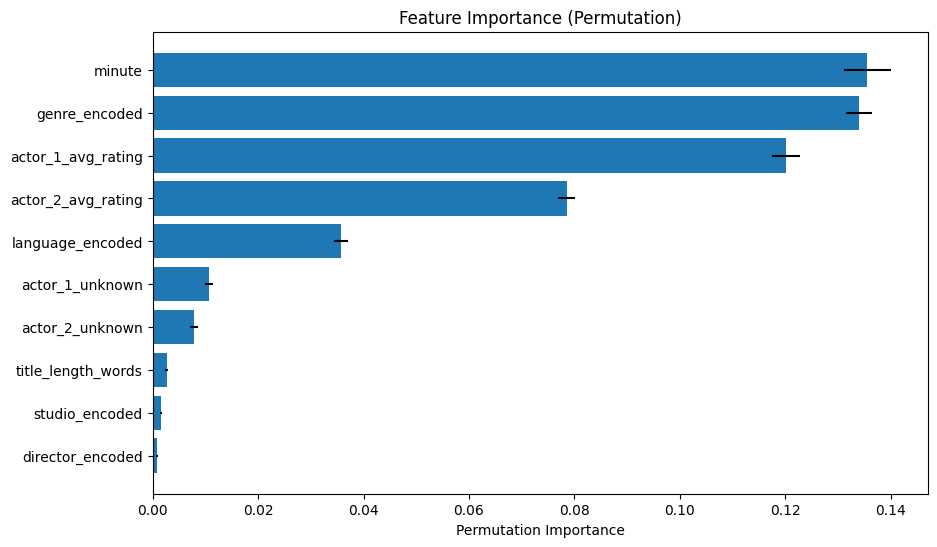

In [17]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance_mean'], xerr=importance_df['importance_std'])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation)')
plt.gca().invert_yaxis()
plt.show()

In [18]:
cols_to_scale = ['minute', 'actor_1_avg_rating', 'actor_2_avg_rating']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(movies_merged[cols_to_scale])

X = movies_merged.copy()

y = X['rating']
X = X.drop(columns=['id', 'description', 'rating', 'name_x', 'date', 'tagline', 'actor_1', 'actor_2', 'country', 'name_y', 'genre_clean', 'language_clean', 'studio', 'title_length_words', 'studio_encoded', 'director_encoded'])
X[cols_to_scale] = X_scaled

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [20]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
print(f"Model score: {model.score(X_test, y_test)}")

Model score: 0.3823761810857773


In [21]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model.predict(X_test)

# Compare predictions with actual values
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

print(predictions_df)  # View first few predictions

# Optional: Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.3f}")

       Actual  Predicted
5877     3.66   3.441325
29251    3.40   3.367839
12543    2.81   3.084481
2050     3.13   3.013965
20727    3.47   3.366095
...       ...        ...
69592    3.06   3.080917
13904    2.73   3.175568
57816    3.13   3.363838
50420    3.00   3.181167
81803    3.52   3.403793

[17253 rows x 2 columns]

Mean Squared Error: 0.117
R² Score: 0.382
